# Выборка #10

In [5]:
%run init.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Обзор данных

In [6]:
dataset = Dataset(10)
dataset.summary()

+---------+-----------------------+----------------------+-------------+------------------+
| Выборка | Обучающая, # объектов | Тестовая, # объектов | # признаков | Доля класса 1, % |
+---------+-----------------------+----------------------+-------------+------------------+
|    10   |          1000         |        10000         |     1500    |       39.0       |
+---------+-----------------------+----------------------+-------------+------------------+


Попробуем сбалансировать выборку оверсэмплингом

In [7]:
from imblearn.over_sampling import SMOTE
#'minority': повторная выборка только класса меньшинства; 
#'not majority': повторная выборка всех классов кроме большого; 
smote = SMOTE(sampling_strategy ='not majority')
X_sm, y_sm = smote.fit_resample(dataset.X1, dataset.y1)
print(y_sm.shape)
print(X_sm.shape)

(1220,)
(1220, 1500)


In [8]:
dataset.X1 = X_sm
dataset.y1 = y_sm
dataset.n_samples = 1220

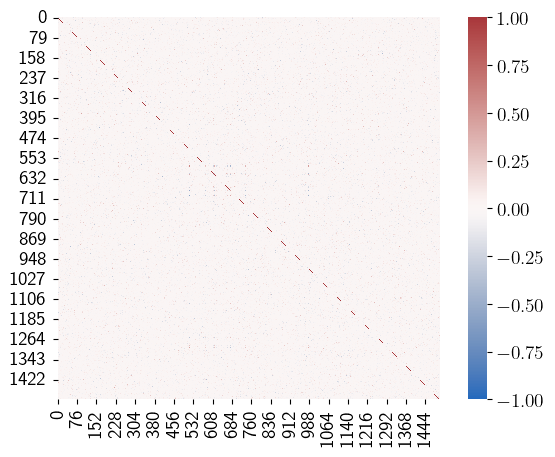

In [3]:
dataset.heatmap()

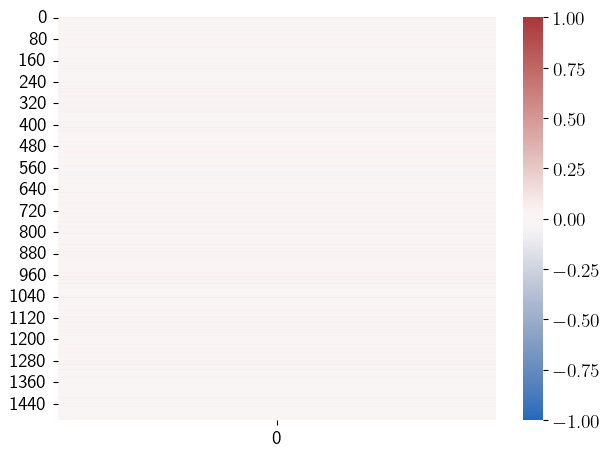

In [4]:
dataset.target_corr(annot=False)

In [5]:
#make_histplot(dataset.df)

### Проверка нормальности признаков

Используем критерий Шапиро-Уилка

In [3]:
pvals = [shapiro(dataset.X1[i])[1] for i in range(dataset.n_features)]

Получим достигаемые уровни значимости для нулевой гипотезы: "Распределение признака является нормальным"

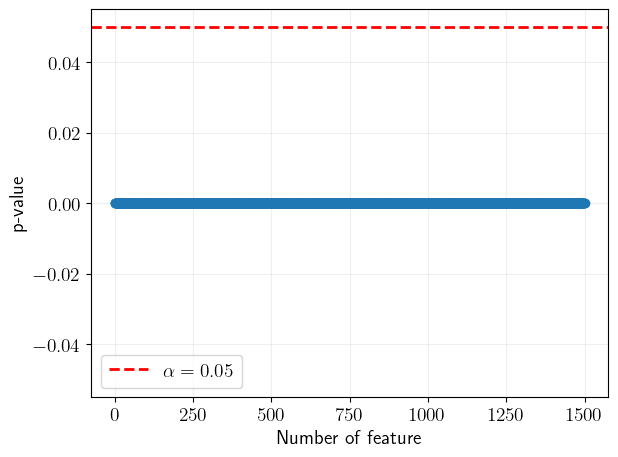

In [7]:
plt.plot(pvals, linestyle='None', marker='o')
plt.axhline(y=0.05, color='r', linestyle='dashed', label=r'$\alpha=0.05$')

plt.legend()
plt.xlabel('Number of feature')
plt.ylabel('p-value')
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

Исключим все объекты со значениями признаков < 0.075-квантиля и больше > 0.925-квантиля

In [9]:
X1_stage1 = dataset.X1[dataset.X1 > dataset.X1.quantile(q=0.075)][dataset.X1 < dataset.X1.quantile(q=0.925)]
X2_stage1 = dataset.X2[dataset.X2 > dataset.X1.quantile(q=0.075)][dataset.X2 < dataset.X1.quantile(q=0.925)]

Заполним все пропущенные значения средними значениями по каждому признаку

In [10]:
X1_stage2 = X1_stage1.fillna(X1_stage1.mean())
X2_stage2 = X2_stage1.fillna(X1_stage1.mean())

Подготовка обработанных датасетов для работы моделей

In [11]:
dataset.X1 = X1_stage2 
dataset.X2 = X2_stage2 

dataset.get_scaled_data()
dataset.get_divergences()

Стандартизуем

In [15]:
scaler = StandardScaler()
X1_stage2_scaled = pd.DataFrame(scaler.fit_transform(X1_stage2))
X2_stage2_scaled = pd.DataFrame(scaler.fit_transform(X2_stage2))

In [16]:
dataset.X1 = X1_stage2
dataset.X2 = X2_stage2

dataset.X1_scaled = X1_stage2_scaled
dataset.X2_scaled = X2_stage2_scaled

<Axes: >

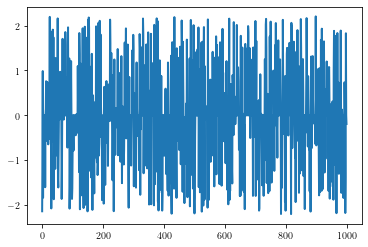

In [17]:
X1_stage2_scaled[100].plot()

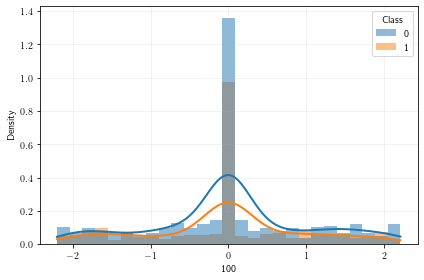

In [18]:
df = pd.concat([X1_stage2_scaled, dataset.y1], axis=1)

sns.histplot(data=df, x=df[100], stat='density', hue='Class', kde=True, edgecolor=None)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

Проверим гипотезу для уже отфильтрованных признаков

In [40]:
pvals = [shapiro(X1_stage2_scaled[i])[1] for i in range(dataset.n_features)]

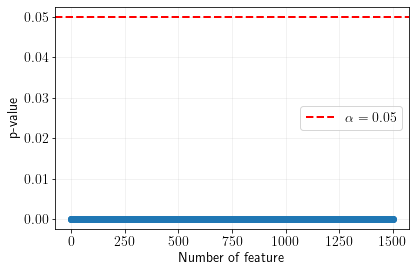

In [41]:
plt.plot(pvals, linestyle='None', marker='o')
plt.axhline(y=0.05, color='r', linestyle='dashed', label=r'$\alpha=0.05$')

plt.legend()
plt.xlabel('Number of feature')
plt.ylabel('p-value')
plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig(f'./fig/dataset_{dataset.dataset_id}/shapiro.pdf', bbox_inches='tight')
plt.show()

Очень похоже на то, что признаки имеют распределение Лапласа.

In [40]:
loc, scale = laplace.fit(X1_stage2_scaled[0])

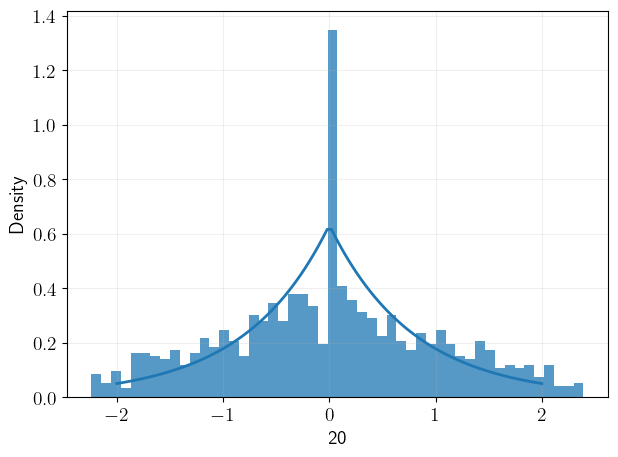

In [41]:
x = np.linspace(-2, 2, 100)
plt.plot(x, laplace.pdf(x, loc=loc, scale=scale))

df = pd.concat([X1_stage2_scaled, dataset.y1], axis=1)
sns.histplot(data=df, x=df[20], bins=50, stat='density', edgecolor=None)

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

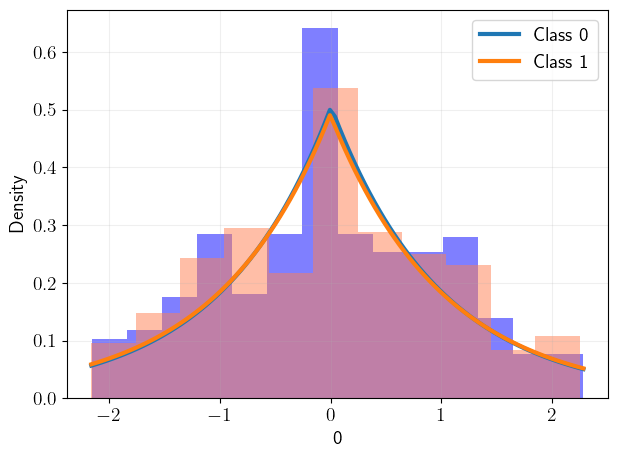

In [42]:
loc_1, scale_1 = norm.fit(X1_stage2_scaled[0][dataset.y1 == 1])
loc_0, scale_0 = norm.fit(X1_stage2_scaled[0][dataset.y1 == 0])

sns.histplot(X1_stage2_scaled[0][dataset.y1 == 0], color='blue', stat='density', edgecolor=None, alpha=0.5)
sns.histplot(X1_stage2_scaled[0][dataset.y1 == 1], color='coral', stat='density', edgecolor=None, alpha=0.5)

grid = np.linspace(min(X1_stage2_scaled[0]), max(X1_stage2_scaled[0]), 100)
plt.plot(grid, laplace.pdf(grid, loc=loc_0, scale=scale_0), linewidth=3, label='Class 0')
plt.plot(grid, laplace.pdf(grid, loc=loc_1, scale=scale_1), linewidth=3, label='Class 1')

plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

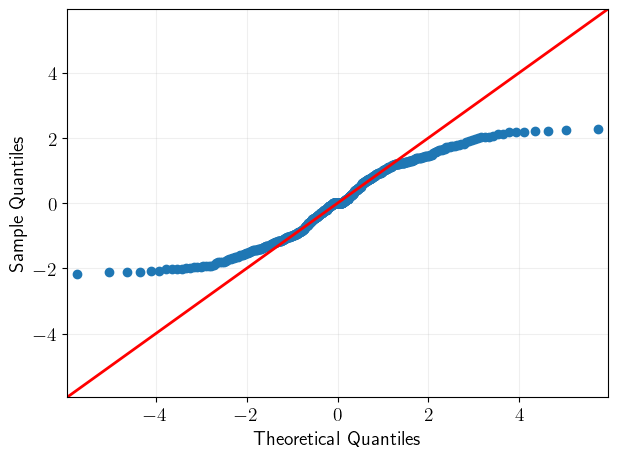

In [43]:
qqplot(data=X1_stage2_scaled[0][dataset.y1 == 0], dist=laplace, fit=True, line='45')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

---

### Logistic Regression

100%|██████████| 39/39 [00:14<00:00,  2.67it/s]


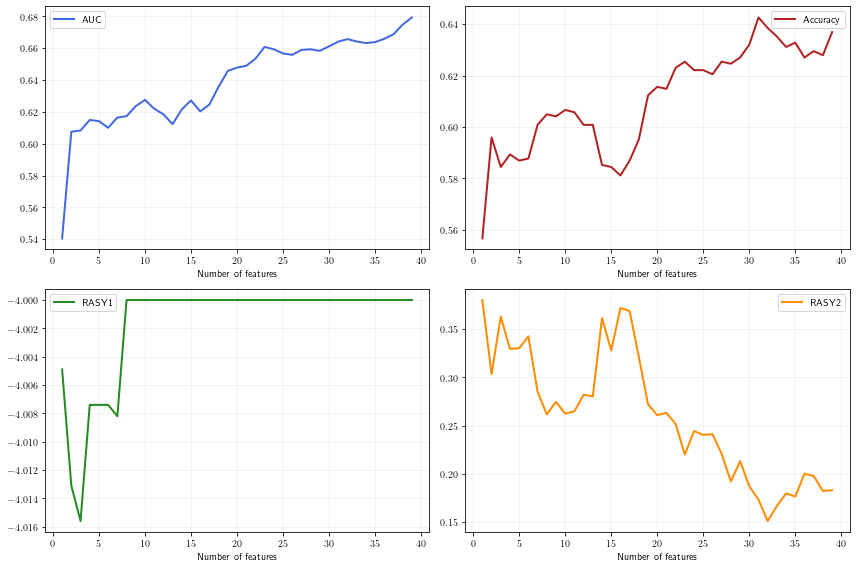

In [13]:
# посмотрим для k<40
features_cols_lr = dataset.metrics_n_features_dependence(LogisticRegression(), ks = range(1, 40))

In [16]:
#Cs_lr = LogisticRegressionValidate(dataset, features_cols_lr, np.logspace(-5, 5, 11))

### Naive Bayes

100%|██████████| 199/199 [00:47<00:00,  4.19it/s]


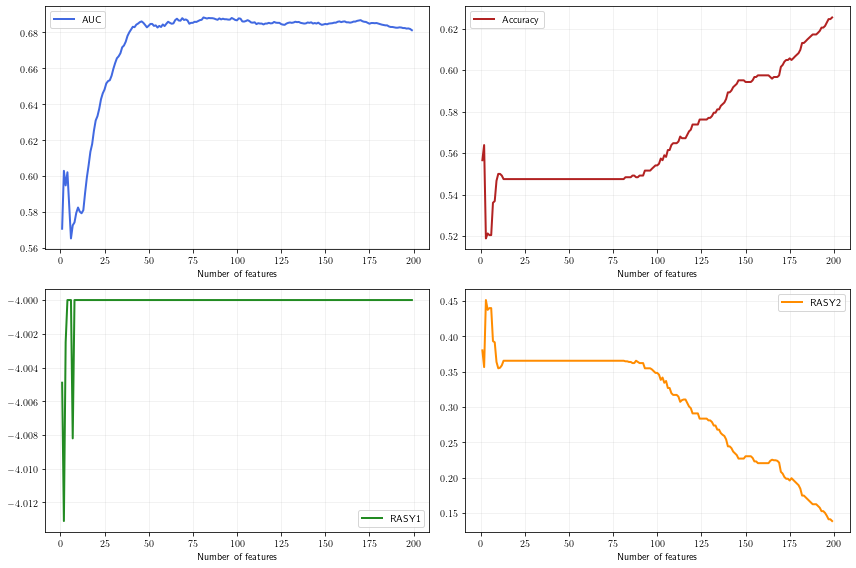

In [17]:
# посмотрим для k<200
features_cols_gnb = dataset.metrics_n_features_dependence(GaussianNB(), ks = range(1, 200))

100%|██████████| 99/99 [22:45<00:00, 13.80s/it]


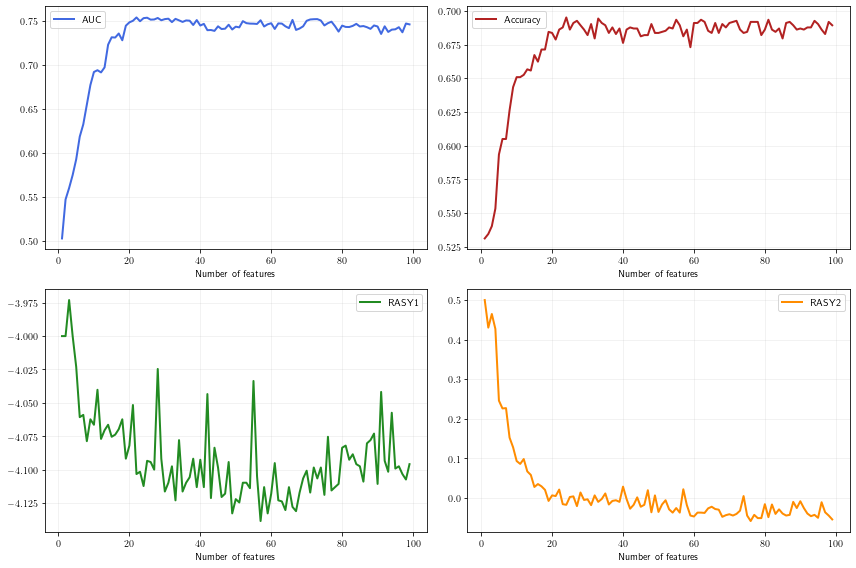

In [19]:
from sklearn.ensemble import RandomForestClassifier

features_cols_rfc = dataset.metrics_n_features_dependence(RandomForestClassifier(n_estimators=500, n_jobs = -1), ks = range(1, 100))

### Saving aswers 

In [20]:
model_AUC = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
model_Accuracy = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
model_RASY1 = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
model_RASY2 = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
models = [model_AUC, model_Accuracy, model_RASY1, model_RASY2]

In [21]:
features_AUC, cols_AUC = features_cols_rfc['AUC']['features'], features_cols_rfc['AUC']['cols']
features_Accuracy, cols_Accuracy = features_cols_rfc['Accuracy']['features'], features_cols_rfc['Accuracy']['cols']
features_RASY1, cols_RASY1 = features_cols_rfc['RASY1']['features'], features_cols_rfc['RASY1']['cols']
features_RASY2, cols_RASY2 = features_cols_rfc['RASY2']['features'], features_cols_rfc['RASY2']['cols']
features_list = [features_AUC, features_Accuracy, features_RASY1, features_RASY2]
cols_list = [cols_AUC, cols_Accuracy, cols_RASY1, cols_RASY2]

In [22]:
t_Accuracy = features_cols_rfc['Accuracy']['t']
t_RASY1 = features_cols_rfc['RASY1']['t']
t_RASY2 = features_cols_rfc['RASY2']['t']
thresholds_list = [t_Accuracy, t_RASY1, t_RASY2]

In [23]:
dataset.save_ans(models, features_list, cols_list, thresholds_list)

In [24]:
[cols_list[i].shape for i in range(4)]

[(22,), (24,), (57,), (76,)]

In [25]:
thresholds_list

[0.5353535353535354, 0.686868686868687, 0.5757575757575758]